# Online ARIMA
- ARIMA-ONS
- Woodbury identity matrix

<b>reference</b></br>
[1]C. Liu, S. C. H. Hoi, P. Zhao, and J. Sun, “Online ARIMA Algorithms for Time Series Prediction,” in Proceedings of the Thirtieth AAAI Conference on Artificial Intelligence, February 12-17, 2016, Phoenix, Arizona, USA, 2016, pp. 1867–1873. [Online]. Available: http://www.aaai.org/ocs/index.php/AAAI/AAAI16/paper/view/12135

In [2]:
import numpy as np
import pandas as pd

<AxesSubplot:>

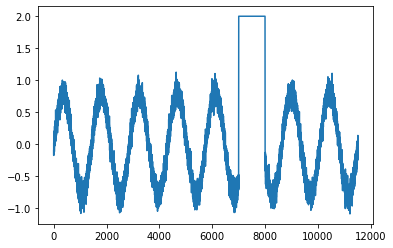

In [78]:
# 生成测试数据
x=np.linspace(0,8*2*np.pi,8*1440)
y=0.8 * np.sin(x) + 0.10 * np.random.randn(8 * 1440)
series = pd.Series(y)
# 注入异常
for i in range(7000, 8000):
    y[i] = 2.0
series.plot.line()

<AxesSubplot:>

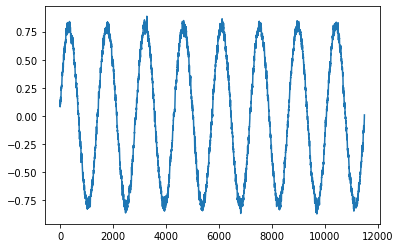

In [77]:
# 使用AutoReg自回归模型
from statsmodels.tsa.ar_model import ar_select_order
mod = ar_select_order(series, maxlag=30)
mod.ar_lags
from statsmodels.tsa.ar_model import AutoReg
res = AutoReg(series, lags = mod.ar_lags).fit()
yhat = []
for i in range(0, 8*1440-30):
    arr = series[i:i+30].values.tolist()
    arr.append(0)
    arr = arr[::-1]
    mask = mod.ar_lags
    yhat.append(np.dot(np.array(arr)[mask], res.params[1:]) + res.params[0])
pd.Series(yhat).plot.line()

<AxesSubplot:>

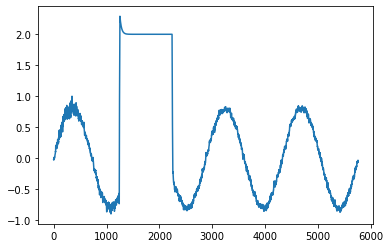

In [79]:
# Functional Test
oarima = OnlineARIMA(series[0:4*1440])
Xhat = []
for i in range(4 * 1440, 8 * 1440):
    xhat = oarima.update(series[i])
    Xhat.append(xhat)
pd.Series(Xhat).plot.line()

<AxesSubplot:>

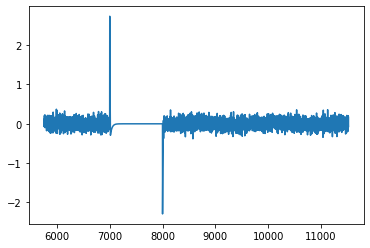

In [81]:
# recon error distribution
(series[4*1440:8*1440] - Xhat).plot.line()

ARIMA生成的重构误差中，以点异常呈现

# Code Repo

In [75]:
class OnlineARIMA:
    '''
        Initialization
        @param series: 1D train data
    '''
    def __init__(self, series, maxlag=30, lrate=1.75, epsilon=10**(-0.5)):
        self.maxlag = maxlag
        self.lrate = lrate
        mod = ar_select_order(series, maxlag=maxlag)
        self.mask = mod.ar_lags
        res = AutoReg(series, lags = mod.ar_lags).fit()
        self.w = res.params[1:]
        self.window = series[-maxlag:].values.tolist()
        self.A_inv = np.eye(len(self.mask)) * epsilon
    
    '''
        Update
    '''
    def update(self, x):
        arr = self.window.copy()
        arr.append(0)
        arr = arr[::-1]
        mask = self.mask
        masked = np.array(arr)[mask]
        xhat = np.dot(masked, self.w)
        diff = xhat - x
        grad = 2 * diff * masked.reshape(1, -1)
        self.A_inv = self.A_inv - self.A_inv @ grad.T * grad * self.A_inv / (1 + grad * self.A_inv * grad.T)
        self.w = self.w - self.lrate * (grad * self.A_inv)[0]
        def update_array(array, update):
            updated = np.roll(array, -1)
            updated[-1] = update
            return updated
        self.window = update_array(self.window, x).tolist()
        return xhat